#### 1. Import packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shap
from plotnine import *
%matplotlib inline

In [4]:
df = pd.read_csv('df_clean.csv')

#### 2. Feature Engineering

In [5]:
print(df['SEX'].value_counts())
print(df['MARRIAGE'].value_counts())

SEX
2    18091
1    11874
Name: count, dtype: int64
MARRIAGE
2    15945
1    13643
3      377
Name: count, dtype: int64


In [6]:
df['SEX_MAR'] = 0
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 1)), 'SEX_MAR'] = 1 #'Married Man'
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 2)), 'SEX_MAR'] = 2 #'Single Man'
df.loc[((df['SEX'] == 1) & (df['MARRIAGE'] == 3)), 'SEX_MAR'] = 3 #'Other Man'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 1)), 'SEX_MAR'] = 4 #'Married Woman'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 2)), 'SEX_MAR'] = 5 #'Single Woman'
df.loc[((df['SEX'] == 2) & (df['MARRIAGE'] == 3)), 'SEX_MAR'] = 6 #'Other Woman'



In [7]:
sex_mar_y_counts = pd.crosstab(df['SEX_MAR'], df['Y'], rownames=['SEX_MAR'], colnames=['Y'], margins=True)
sex_mar_y_counts['% Default'] = (sex_mar_y_counts[1]/sex_mar_y_counts['All']) * 100
sex_mar_y_counts

Y,0,1,All,% Default
SEX_MAR,,,,
1,3841,1343,5184,25.906636
2,5061,1484,6545,22.673797
3,103,42,145,28.965517
4,6601,1858,8459,21.964771
5,7544,1856,9400,19.744681
6,185,47,232,20.258621
All,23335,6630,29965,22.125813


Married men have higher default % than married women. Each marriage status, men have higher default % as well.

In [8]:
for i in range(1, 7):
    ratio = df[f'PAY_RATIO_{i}'] = (df[f'PAY_AMT{i}'] / df[f'BILL_AMT{i}'])
    ratio.replace([np.inf, -np.inf], np.nan, inplace = True)
    df[f'PAY_RATIO_{i}'] = ratio.fillna(0)

In [9]:
for i in range(1, 7):
    util = df[f'CREDIT_UTILIZATION_{i}'] = (df[f'BILL_AMT{i}'] / df[f'LIMIT_BAL'])
    util.replace([np.inf, -np.inf], np.nan, inplace = True)
    df[f'CREDIT_UTILIZATION_{i}'] = ratio.fillna(0)


I want to see how much customers spend on average in proportion to their credit limit.

new balance = previous balance - payment + new charges <br>
new charges = previous balance - payment - new balance <br>
            = payment - previous balance + new balance <br>
            = payment - (previous balance - new balance) <br>

In [10]:
df['AVG_EXP_5'] = (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6']))/df['LIMIT_BAL'] # Spending in May

df['AVG_EXP_4'] = (((df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6']))) / 2 )/df['LIMIT_BAL'] # Spending in June

df['AVG_EXP_3'] = (((df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/3)/df['LIMIT_BAL'] # Spending in July

df['AVG_EXP_2'] = (((df['PAY_2'] - (df['BILL_AMT2'] - df['BILL_AMT3'])) 
                + (df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/4)/df['LIMIT_BAL'] # Spending in August

df['AVG_EXP_1'] = (((df['PAY_1'] - (df['BILL_AMT1'] - df['BILL_AMT2']))
                + (df['PAY_2'] - (df['BILL_AMT2'] - df['BILL_AMT3'])) 
                + (df['PAY_3'] - (df['BILL_AMT3'] - df['BILL_AMT4'])) 
                + (df['PAY_4'] - (df['BILL_AMT4'] - df['BILL_AMT5'])) 
                + (df['PAY_5'] - (df['BILL_AMT5'] - df['BILL_AMT6'])))/5)/df['LIMIT_BAL'] # Spending in September

In [11]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,CREDIT_UTILIZATION_2,CREDIT_UTILIZATION_3,CREDIT_UTILIZATION_4,CREDIT_UTILIZATION_5,CREDIT_UTILIZATION_6,AVG_EXP_5,AVG_EXP_4,AVG_EXP_3,AVG_EXP_2,AVG_EXP_1
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.842750,1.557283,35.487969,0.356416,0.320340,0.304288,0.258935,0.221625,...,-0.601042,-0.601042,-0.601042,-0.601042,-0.601042,-0.014535,-0.020477,-0.024558,-0.023157,-0.021055
std,129760.135222,0.489128,0.744513,0.521431,9.219459,0.760752,0.802064,0.790696,0.761200,0.717768,...,80.629341,80.629341,80.629341,80.629341,80.629341,0.141948,0.099833,0.083920,0.069900,0.060307
min,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-11349.571429,-11349.571429,-11349.571429,-11349.571429,-11349.571429,-4.928000,-2.319000,-3.043933,-1.364050,-1.061900
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015100,-0.020391,-0.030473,-0.035388,-0.036360
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.039551,0.039551,0.039551,0.039551,0.039551,0.000000,0.000000,-0.000537,-0.000953,-0.001384
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.146817,0.146817,0.146817,0.146817,0.146817,0.011725,0.008250,0.006362,0.006018,0.005850
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,2643.330000,2643.330000,2643.330000,2643.330000,2643.330000,2.008971,1.136875,0.634667,0.456825,0.365460


New variables, SEX_MAR,PAY_RATIO_i, CREDIT_UTILIZATION_i, AVG_EXP_i are created.

#### 3. Feature Importance - Random Forest Classifier

##### a)Set target variable

In [12]:
y = df['Y'].copy()
X = df.drop('Y', axis =1 ).copy()

##### b)Data split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

##### c)Random Forest Classifier for Feature Importance

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)


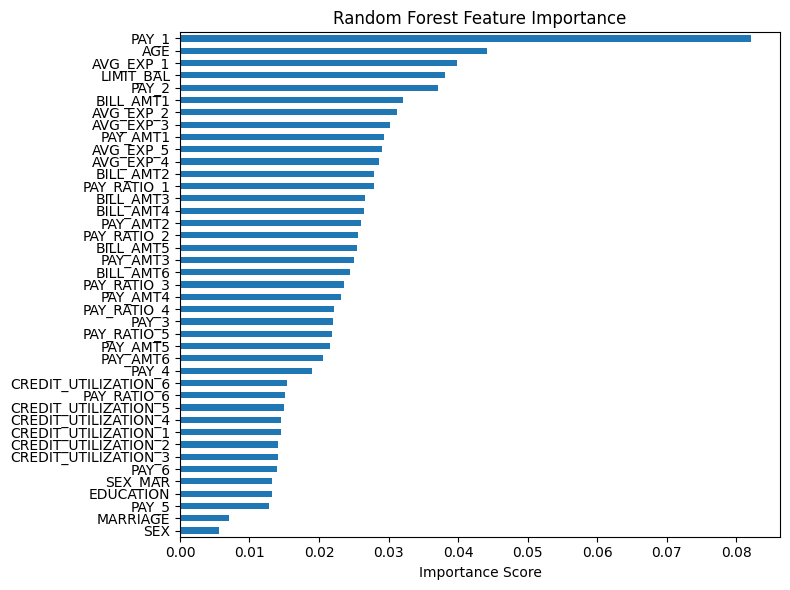

PAY_1                   0.082196
AGE                     0.044233
AVG_EXP_1               0.039789
LIMIT_BAL               0.038153
PAY_2                   0.037109
BILL_AMT1               0.032069
AVG_EXP_2               0.031191
AVG_EXP_3               0.030261
PAY_AMT1                0.029286
AVG_EXP_5               0.028997
AVG_EXP_4               0.028682
BILL_AMT2               0.027913
PAY_RATIO_1             0.027901
BILL_AMT3               0.026670
BILL_AMT4               0.026400
PAY_AMT2                0.026013
PAY_RATIO_2             0.025565
BILL_AMT5               0.025459
PAY_AMT3                0.025064
BILL_AMT6               0.024462
PAY_RATIO_3             0.023624
PAY_AMT4                0.023163
PAY_RATIO_4             0.022126
PAY_3                   0.022026
PAY_RATIO_5             0.021849
PAY_AMT5                0.021629
PAY_AMT6                0.020620
PAY_4                   0.018970
CREDIT_UTILIZATION_6    0.015332
PAY_RATIO_6             0.015125
CREDIT_UTI

In [15]:
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print(importances.sort_values(ascending=False))

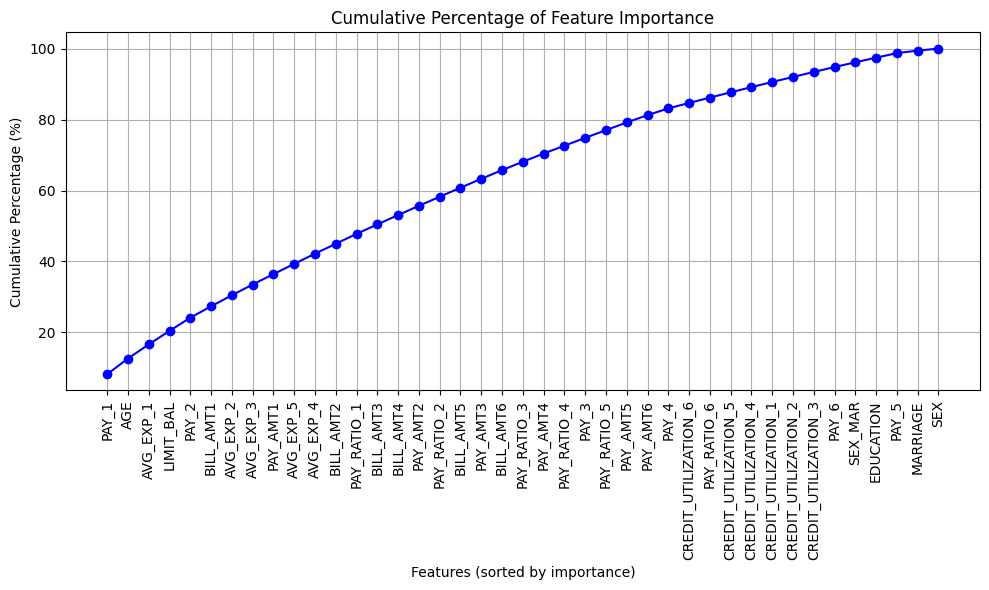

In [16]:
# Calculate cumulative percentage
importances_sorted = importances.sort_values(ascending=False)
cumulative_importance = importances_sorted.cumsum() / importances_sorted.sum() * 100

# Plot cumulative percentage
plt.figure(figsize=(10, 6))
plt.plot(cumulative_importance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Percentage of Feature Importance')
plt.xlabel('Features (sorted by importance)')
plt.ylabel('Cumulative Percentage (%)')
plt.xticks(ticks=range(len(importances_sorted)), labels=importances_sorted.index, rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
pay_ratio_columns = [f'PAY_RATIO_{i}' for i in range(1, 7)]
pay_amt_columns = [f'PAY_AMT{i}' for i in range(1, 7)]

correlation_matrix = df[pay_ratio_columns + pay_amt_columns].corr()

# Extract correlations between PAY_RATIO and PAY_AMT columns
correlation = correlation_matrix.loc[pay_ratio_columns, pay_amt_columns]
print(correlation)

             PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6
PAY_RATIO_1 -0.006287 -0.009689 -0.004857 -0.004075 -0.000855 -0.024695
PAY_RATIO_2  0.007847 -0.074907  0.004680  0.003244 -0.005459  0.000530
PAY_RATIO_3  0.002625  0.003040 -0.042917  0.002302  0.000484  0.001732
PAY_RATIO_4  0.004682  0.002444  0.005213  0.013364  0.001178  0.003723
PAY_RATIO_5  0.001881  0.008601  0.003438  0.004777  0.001610  0.006370
PAY_RATIO_6  0.003928  0.009775 -0.011822 -0.008748  0.004693  0.017924


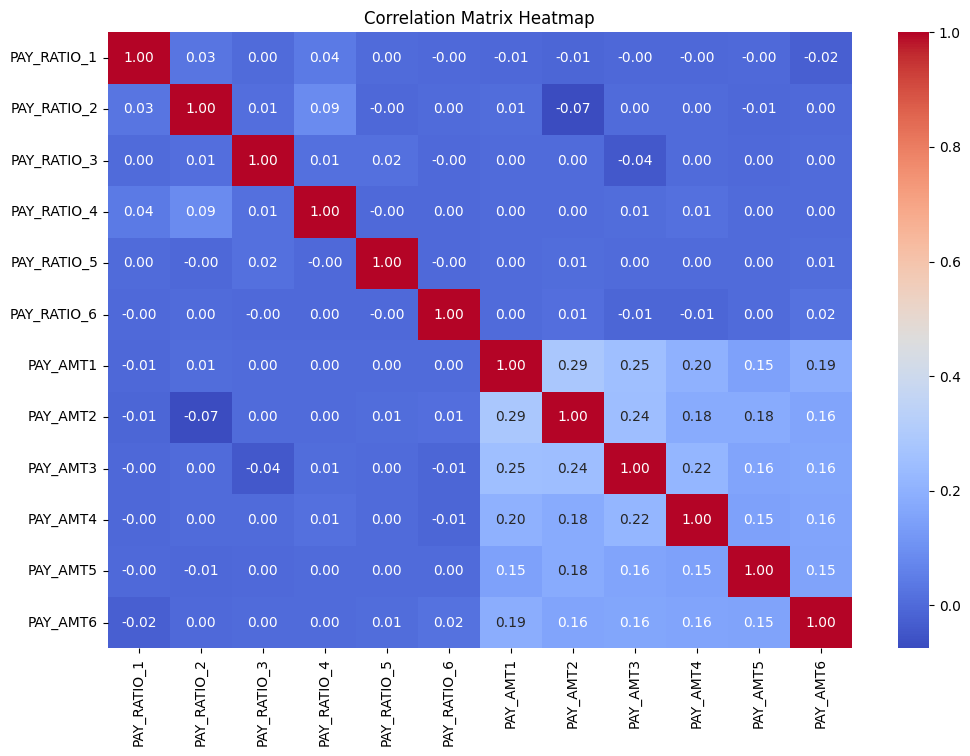

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

Dropping columns: SEX, MARRIAGE, CREDIT_UTILIZATION

In [19]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y',
       'SEX_MAR', 'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4',
       'PAY_RATIO_5', 'PAY_RATIO_6', 'CREDIT_UTILIZATION_1',
       'CREDIT_UTILIZATION_2', 'CREDIT_UTILIZATION_3', 'CREDIT_UTILIZATION_4',
       'CREDIT_UTILIZATION_5', 'CREDIT_UTILIZATION_6', 'AVG_EXP_5',
       'AVG_EXP_4', 'AVG_EXP_3', 'AVG_EXP_2', 'AVG_EXP_1'],
      dtype='object')

In [20]:
df.shape

(29965, 42)

##### d)Feature Selection

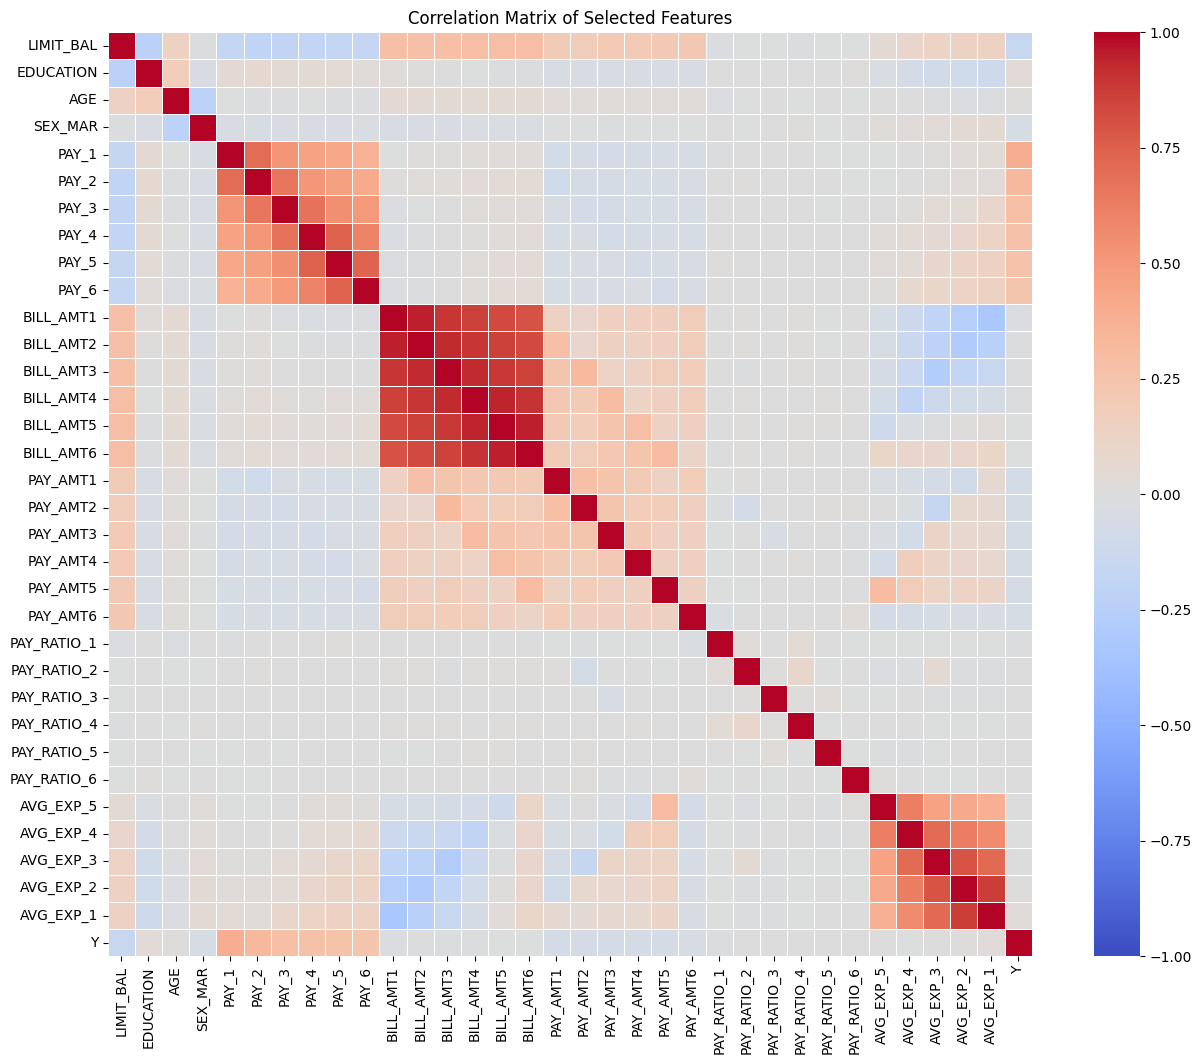

In [21]:
features = [
    'LIMIT_BAL', 'EDUCATION', 'AGE', 'SEX_MAR',
    'PAY_1', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6', 
    'AVG_EXP_5','AVG_EXP_4', 'AVG_EXP_3', 'AVG_EXP_2', 'AVG_EXP_1','Y'
]

selected_df = df[features]

corr_matrix = selected_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True, linewidths=0.5, vmax=1, vmin=-1)
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [22]:
selected_df.shape

(29965, 34)

In [23]:
y = selected_df['Y'].copy()
X = selected_df.drop('Y', axis =1 ).copy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

In [25]:
X_train.shape

(23972, 33)

In [26]:
X_test.shape

(5993, 33)

#### 4. Data Preprocessing

##### a) Sampling - without sampling technique

In [27]:
df_normal = X_train.join(y_train)
print(df_normal.head())
print(df_normal.shape)

       LIMIT_BAL  EDUCATION  AGE  SEX_MAR  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  \
7641      150000          1   30        4      1      2      0      0      0   
14609     230000          1   34        4      0      0      0      0      0   
23282     300000          2   42        4      0      0      0      0      0   
21193     250000          2   45        1      0      0      0      0      0   
9336       20000          3   50        5      0      0      0      0      0   

       PAY_6  ...  PAY_RATIO_3  PAY_RATIO_4  PAY_RATIO_5  PAY_RATIO_6  \
7641       2  ...     0.000048     0.193280     0.000000    72.339080   
14609      0  ...     0.586436     0.707653     0.881965     0.521675   
23282      0  ...     0.043708     0.030315     0.041732     0.040423   
21193      0  ...     0.036210     0.019886     0.040308     0.051593   
9336       0  ...     0.054089     0.052140     0.031744     0.015135   

       AVG_EXP_5  AVG_EXP_4  AVG_EXP_3  AVG_EXP_2  AVG_EXP_1  Y  
7641    0.0000

##### b) Sampling - oversampling minority

In [28]:
df_majority = df_normal[df_normal['Y'] == 0]
df_minority = df_normal[df_normal['Y'] == 1]

In [29]:
print(df_majority.shape)
print(df_minority.shape)

(18685, 34)
(5287, 34)


In [30]:
from sklearn.utils import resample

df_minority_oversampled = resample(df_minority, replace = True, n_samples = 18685, random_state = 100)

df_oversampled = pd.concat([df_majority, df_minority_oversampled])

df_oversampled.Y.value_counts()

Y
0    18685
1    18685
Name: count, dtype: int64

##### c) Sampling - undersampling majority

In [31]:
df_majority_undersampled = resample(df_majority, replace = False, n_samples = 5287, random_state= 100)

df_undersampled = pd.concat([df_minority, df_majority_undersampled])

df_undersampled.Y.value_counts()

Y
1    5287
0    5287
Name: count, dtype: int64

##### d) Sampling - SMOTE

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
sm = SMOTE(random_state= 100)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

print(len(X_SMOTE))
print(len(y_SMOTE))
print(y_SMOTE.sum())


37370
37370
18685


In [34]:
y_train.value_counts()

Y
0    18685
1     5287
Name: count, dtype: int64

In [35]:
y_SMOTE.value_counts()

Y
0    18685
1    18685
Name: count, dtype: int64

##### e) Scaling

In [36]:
scaler = StandardScaler()

In [37]:
y = df_normal['Y'].copy()
X = df_normal.drop('Y', axis =1 ).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 100, shuffle=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [38]:
y_os = df_oversampled['Y'].copy()
X_os = df_oversampled.drop('Y', axis =1 ).copy()

X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, train_size = 0.8, random_state = 100, shuffle=True)

X_train_os_scaled = scaler.fit_transform(X_train_os)
X_test_os_scaled = scaler.fit_transform(X_test_os)

In [39]:
y_us = df_undersampled['Y'].copy()
X_us = df_undersampled.drop('Y', axis =1 ).copy()

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, train_size = 0.8, random_state = 100, shuffle=True)

X_train_us_scaled = scaler.fit_transform(X_train_us)
X_test_us_scaled = scaler.fit_transform(X_test_us)

In [40]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_SMOTE, y_SMOTE, train_size = 0.8, random_state = 100, shuffle=True)

X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_sm_scaled = scaler.fit_transform(X_test_sm)

#### 5. Model Building

In [41]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

def evaluate_model(y_true, y_pred):
    """
    Evaluate a classification model using various metrics.

    Parameters:
    y_true (pd.Series): True labels.
    y_pred (np.ndarray): Predicted labels.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """
    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    # Miss rate
    miss_rate = FN / (FN + TP) if (FN + TP) > 0 else 0

    # Print metrics
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"True Positives (TP): {TP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Positives (FP): {FP}")
    print(f"False Negatives (FN): {FN}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Miss Rate: {miss_rate:.2f}")

    return {
            "F1 Score": round(f1, 2),
            "Accuracy": round(accuracy, 2),
            "Precision": round(precision, 2),
            "Recall": round(recall, 2),
            "Miss Rate": round(miss_rate, 2)
        }
summary = []

##### a) Bagging - Random Forest Classifier

In [42]:
# set up parameters
rfc_metric = 'gini'
random_state = 100

# initialize the classifier
rfc = RandomForestClassifier(random_state = random_state,
                            criterion = rfc_metric)
                            


In [43]:
# train the model on normal sample data
rfc.fit(X_train_scaled, y_train)
rfc_pred = rfc.predict(X_test_scaled)

rfc_pred_metrics = evaluate_model(y_test, rfc_pred)
rfc_pred_metrics["Model"] = "Random Forest Normal Sample"
summary.append(rfc_pred_metrics)

F1 Score: 0.39
Accuracy: 0.81
True Positives (TP): 281
True Negatives (TN): 3623
False Positives (FP): 135
False Negatives (FN): 756
Recall: 0.27
Precision: 0.68
Miss Rate: 0.73


In [44]:
# train the model on oversampled data
rfc.fit(X_train_os_scaled, y_train_os)
rfc_pred_os = rfc.predict(X_test_os_scaled)

rfc_pred_os_metrics = evaluate_model(y_test_os, rfc_pred_os)
rfc_pred_os_metrics["Model"] = "Random Forest Oversampled"
summary.append(rfc_pred_os_metrics)

F1 Score: 0.64
Accuracy: 0.72
True Positives (TP): 1845
True Negatives (TN): 3548
False Positives (FP): 193
False Negatives (FN): 1888
Recall: 0.49
Precision: 0.91
Miss Rate: 0.51


In [45]:
# train the model on undersampled data
rfc.fit(X_train_us_scaled, y_train_us)
rfc_pred_us = rfc.predict(X_test_us_scaled)

rfc_pred_us_metrics = evaluate_model(y_test_us, rfc_pred_us)
rfc_pred_us_metrics["Model"] = "Random Forest Undersampled"
summary.append(rfc_pred_us_metrics)

F1 Score: 0.66
Accuracy: 0.70
True Positives (TP): 617
True Negatives (TN): 874
False Positives (FP): 205
False Negatives (FN): 419
Recall: 0.60
Precision: 0.75
Miss Rate: 0.40


In [46]:
# train the model on SMOTE data
rfc.fit(X_train_sm_scaled, y_train_sm)
rfc_pred_sm = rfc.predict(X_test_sm_scaled)

rfc_pred_sm_metrics = evaluate_model(y_test_sm, rfc_pred_sm)
rfc_pred_sm_metrics["Model"] = "Random Forest SMOTE"
summary.append(rfc_pred_sm_metrics)

F1 Score: 0.74
Accuracy: 0.77
True Positives (TP): 2496
True Negatives (TN): 3235
False Positives (FP): 510
False Negatives (FN): 1233
Recall: 0.67
Precision: 0.83
Miss Rate: 0.33


##### b) Boosting - AdaBoost: focusing on misclassification and assigning larger weights in sequential training.

In [47]:
from sklearn.ensemble import AdaBoostClassifier

# set up parameters
learning_rate = 0.1
n_estimators = 100
random_state = 100

# initialize the classifier
abc = AdaBoostClassifier(n_estimators= n_estimators,
                            random_state = random_state,
                            learning_rate=learning_rate)

In [48]:
# train the model on normal sample data
abc.fit(X_train_scaled, y_train)
abc_pred = abc.predict(X_test_scaled)

abc_pred_metrics = evaluate_model(y_test, abc_pred)
abc_pred_metrics["Model"] = "AdaBoost Normal Sample"
summary.append(abc_pred_metrics)

F1 Score: 0.42
Accuracy: 0.82
True Positives (TP): 309
True Negatives (TN): 3631
False Positives (FP): 127
False Negatives (FN): 728
Recall: 0.30
Precision: 0.71
Miss Rate: 0.70


In [49]:
# train the model on oversampled data
abc.fit(X_train_os_scaled, y_train_os)
abc_pred_os = abc.predict(X_test_os_scaled)

abc_pred_os_metrics = evaluate_model(y_test_os, abc_pred_os)
abc_pred_os_metrics["Model"] = "AdaBoost Oversampled"
summary.append(abc_pred_os_metrics)

F1 Score: 0.63
Accuracy: 0.70
True Positives (TP): 1969
True Negatives (TN): 3226
False Positives (FP): 515
False Negatives (FN): 1764
Recall: 0.53
Precision: 0.79
Miss Rate: 0.47


In [50]:
# train the model on undersampled data
abc.fit(X_train_us_scaled, y_train_us)
abc_pred_us = abc.predict(X_test_us_scaled)

abc_pred_us_metrics = evaluate_model(y_test_us, abc_pred_us)
abc_pred_us_metrics["Model"] = "AdaBoost Undersampled"
summary.append(abc_pred_us_metrics)

F1 Score: 0.66
Accuracy: 0.71
True Positives (TP): 583
True Negatives (TN): 925
False Positives (FP): 154
False Negatives (FN): 453
Recall: 0.56
Precision: 0.79
Miss Rate: 0.44


In [51]:
# train the model on SMOTE data
abc.fit(X_train_sm_scaled, y_train_sm)
abc_pred_sm = abc.predict(X_test_sm_scaled)

abc_pred_sm_metrics = evaluate_model(y_test_sm, abc_pred_sm)
abc_pred_sm_metrics["Model"] = "AdaBoost SMOTE"
summary.append(abc_pred_sm_metrics)

F1 Score: 0.65
Accuracy: 0.71
True Positives (TP): 2092
True Negatives (TN): 3178
False Positives (FP): 567
False Negatives (FN): 1637
Recall: 0.56
Precision: 0.79
Miss Rate: 0.44


##### c) Boosting - Gradient Boosting Machine: focusing on misclassification with gradient descents in iterative training.

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

# set up parameters
learning_rate = 0.1
n_estimators = 100
random_state = 100

# initialize the classifier
gbm = GradientBoostingClassifier(n_estimators= n_estimators,
                            random_state = random_state,
                            learning_rate=learning_rate)

In [53]:
# train the model on normal sample data
gbm.fit(X_train_scaled, y_train)
gbm_pred = gbm.predict(X_test_scaled)

gbm_pred_metrics = evaluate_model(y_test, gbm_pred)
gbm_pred_metrics["Model"] = "GBM Normal Sample"
summary.append(gbm_pred_metrics)

F1 Score: 0.46
Accuracy: 0.82
True Positives (TP): 361
True Negatives (TN): 3578
False Positives (FP): 180
False Negatives (FN): 676
Recall: 0.35
Precision: 0.67
Miss Rate: 0.65


In [54]:
# train the model on oversampled data
gbm.fit(X_train_os_scaled, y_train_os)
gbm_pred_os = gbm.predict(X_test_os_scaled)

gbm_pred_os_metrics = evaluate_model(y_test_os, gbm_pred_os)
gbm_pred_os_metrics["Model"] = "GBM Oversampled"
summary.append(gbm_pred_os_metrics)

F1 Score: 0.70
Accuracy: 0.72
True Positives (TP): 2414
True Negatives (TN): 2971
False Positives (FP): 770
False Negatives (FN): 1319
Recall: 0.65
Precision: 0.76
Miss Rate: 0.35


In [55]:
# train the model on undersampled data
gbm.fit(X_train_us_scaled, y_train_us)
gbm_pred_us = gbm.predict(X_test_us_scaled)

gbm_pred_us_metrics = evaluate_model(y_test_us, gbm_pred_us)
gbm_pred_us_metrics["Model"] = "GBM Undersampled"
summary.append(gbm_pred_us_metrics)

F1 Score: 0.69
Accuracy: 0.72
True Positives (TP): 682
True Negatives (TN): 832
False Positives (FP): 247
False Negatives (FN): 354
Recall: 0.66
Precision: 0.73
Miss Rate: 0.34


In [56]:
# train the model on SMOTE data
gbm.fit(X_train_sm_scaled, y_train_sm)
gbm_pred_sm = gbm.predict(X_test_sm_scaled)

gbm_pred_sm_metrics = evaluate_model(y_test_sm, gbm_pred_sm)
gbm_pred_sm_metrics["Model"] = "GBM SMOTE"
summary.append(gbm_pred_sm_metrics)

F1 Score: 0.74
Accuracy: 0.76
True Positives (TP): 2625
True Negatives (TN): 3027
False Positives (FP): 718
False Negatives (FN): 1104
Recall: 0.70
Precision: 0.79
Miss Rate: 0.30


##### d) Boosting - Light Gradient Boosting Machine: reducing the number of data instances and features to scan for maximizing efficiency.

In [57]:
from lightgbm import LGBMClassifier

# Set up parameters
learning_rate = 0.1
n_estimators = 100
random_state = 100

# Initialize the classifier
lgbm = LGBMClassifier(n_estimators=n_estimators,
                      learning_rate=learning_rate,
                      random_state=random_state)


In [58]:
# train the model on normal sample data
lgbm.fit(X_train_scaled, y_train)
lgbm_pred = lgbm.predict(X_test_scaled)

lgbm_pred_metrics = evaluate_model(y_test, lgbm_pred)
lgbm_pred_metrics["Model"] = "LightGBM Normal Sample"
summary.append(lgbm_pred_metrics)

[LightGBM] [Info] Number of positive: 4250, number of negative: 14927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6059
[LightGBM] [Info] Number of data points in the train set: 19177, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221620 -> initscore=-1.256253
[LightGBM] [Info] Start training from score -1.256253
F1 Score: 0.38
Accuracy: 0.82
True Positives (TP): 266
True Negatives (TN): 3656
False Positives (FP): 102
False Negatives (FN): 771
Recall: 0.26
Precision: 0.72
Miss Rate: 0.74


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [59]:
# train the model on oversampled data
lgbm.fit(X_train_os_scaled, y_train_os)
lgbm_pred_os = lgbm.predict(X_test_os_scaled)

lgbm_pred_os_metrics = evaluate_model(y_test_os, lgbm_pred_os)
lgbm_pred_os_metrics["Model"] = "LightGBM Oversampled"
summary.append(lgbm_pred_os_metrics)

[LightGBM] [Info] Number of positive: 14952, number of negative: 14944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6063
[LightGBM] [Info] Number of data points in the train set: 29896, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500134 -> initscore=0.000535
[LightGBM] [Info] Start training from score 0.000535
F1 Score: 0.70
Accuracy: 0.73
True Positives (TP): 2348
True Negatives (TN): 3109
False Positives (FP): 632
False Negatives (FN): 1385
Recall: 0.63
Precision: 0.79
Miss Rate: 0.37


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [60]:
# train the model on undersampled data
lgbm.fit(X_train_us_scaled, y_train_us)
lgbm_pred_us = lgbm.predict(X_test_us_scaled)

lgbm_pred_us_metrics = evaluate_model(y_test_us, lgbm_pred_us)
lgbm_pred_us_metrics["Model"] = "LightGBM Undersampled"
summary.append(lgbm_pred_us_metrics)

[LightGBM] [Info] Number of positive: 4251, number of negative: 4208
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6041
[LightGBM] [Info] Number of data points in the train set: 8459, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502542 -> initscore=0.010167
[LightGBM] [Info] Start training from score 0.010167
F1 Score: 0.68
Accuracy: 0.70
True Positives (TP): 672
True Negatives (TN): 813
False Positives (FP): 266
False Negatives (FN): 364
Recall: 0.65
Precision: 0.72
Miss Rate: 0.35


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [61]:
# train the model on SMOTE data
lgbm.fit(X_train_sm_scaled, y_train_sm)
lgbm_pred_sm = lgbm.predict(X_test_sm_scaled)

lgbm_pred_sm_metrics = evaluate_model(y_test_sm, lgbm_pred_sm)
lgbm_pred_sm_metrics["Model"] = "LightGBM SMOTE"
summary.append(lgbm_pred_sm_metrics)

[LightGBM] [Info] Number of positive: 14956, number of negative: 14940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6246
[LightGBM] [Info] Number of data points in the train set: 29896, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500268 -> initscore=0.001070
[LightGBM] [Info] Start training from score 0.001070
F1 Score: 0.75
Accuracy: 0.72
True Positives (TP): 3143
True Negatives (TN): 2245
False Positives (FP): 1500
False Negatives (FN): 586
Recall: 0.84
Precision: 0.68
Miss Rate: 0.16


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names


In [62]:
summary_df = pd.DataFrame(summary)

In [63]:
new_order = ['Model', 'F1 Score', 'Accuracy', 'Precision', 'Recall', 'Miss Rate']
summary_df = summary_df[new_order]

summary_df

,Model,F1 Score,Accuracy,Precision,Recall,Miss Rate
0,Random Forest Normal Sample,0.39,0.81,0.68,0.27,0.73
1,Random Forest Oversampled,0.64,0.72,0.91,0.49,0.51
2,Random Forest Undersampled,0.66,0.70,0.75,0.60,0.40
3,Random Forest SMOTE,0.74,0.77,0.83,0.67,0.33
4,AdaBoost Normal Sample,0.42,0.82,0.71,0.30,0.70
5,AdaBoost Oversampled,0.63,0.70,0.79,0.53,0.47
6,AdaBoost Undersampled,0.66,0.71,0.79,0.56,0.44
7,AdaBoost SMOTE,0.65,0.71,0.79,0.56,0.44
8,GBM Normal Sample,0.46,0.82,0.67,0.35,0.65
9,GBM Oversampled,0.70,0.72,0.76,0.65,0.35


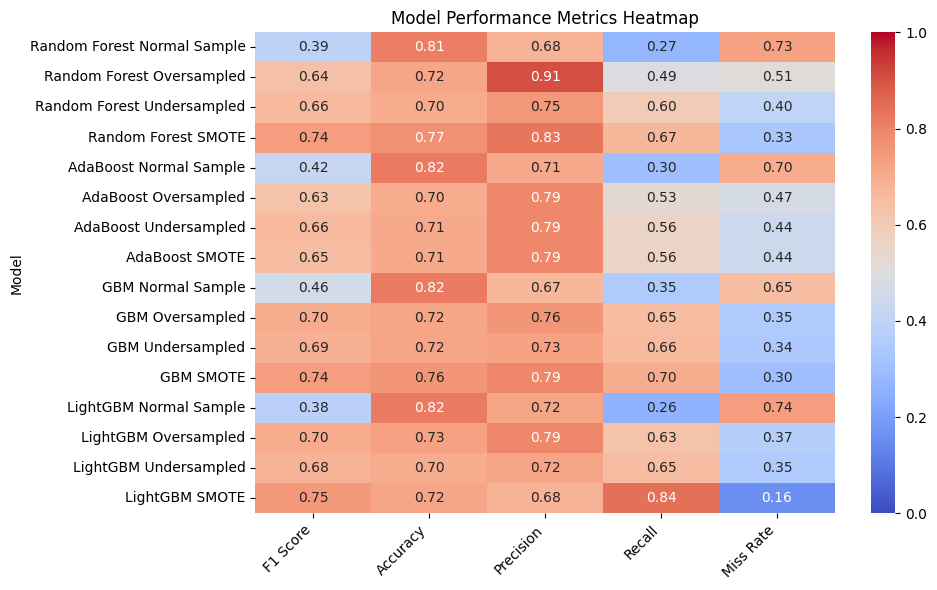

In [64]:
plt.figure(figsize=(10, 6))
sns.heatmap(summary_df.set_index('Model'), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, vmax=1, vmin=0)
plt.title("Model Performance Metrics Heatmap")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [65]:
print(f"Length of normal sample training data:",len(X_train_scaled))
print(f"Length of minority random over sample training data:",len(X_train_os_scaled))
print(f"Length of majority random under sample training data:",len(X_train_us_scaled))
print(f"Length of SMOTE sample training data:",len(X_train_sm_scaled))

print(f"Undersampling has reduced the dataset by",round((len(X_train_us_scaled)/len(X_train_scaled)-1)*-100,2),"%")

Length of normal sample training data: 19177
Length of minority random over sample training data: 29896
Length of majority random under sample training data: 8459
Length of SMOTE sample training data: 29896
Undersampling has reduced the dataset by 55.89 %


#### Model performance summary
I've trained one bagging model, random forest classifier, and three boosting models, including AdaBoost, GBM, and LightGBM. They were trained using four sample data; normal sample, minority oversampled, majority undersampled, and SMOTE (synthetic minority oversampling technique; SMOTE generates extra minority data points synthetically by interpolating existing neighbor values.) For each model, default hyperparameters were used. 

For evaluation metrics, F1 score, accuracy, precision, recall, and miss rate are included. F1 score represents harmonic mean between precision and recall. Accuracy indicates how many classes are correctly classified overall. Precision represents how many default predictions are true, of all default predictions. Recall indicates how many defaults the model catches, of all actual defaults.

The results show that models trained on normal samples are low in F1 score and recall due to the imbalance of the data. Accuracy and precision are high, but these metrics may not be informative in the imbalanced sample. Models trained on minority random oversamples achieved decent precision, but low recall, meaning the models classification on defaults were generally correct, but they also missed many defaults. Models trained on majority undersampled have significantly reduced number of data instances, which increases the model variance, sensitive to small changes in training data. It is seen that undersampled data has reduced about 55.8% of the original training data. Models on SMOTE data overall achieved the best performance across all metrics. Especially, LightGBM achieved overall best classification performance.

In [66]:
summary_df

,Model,F1 Score,Accuracy,Precision,Recall,Miss Rate
0,Random Forest Normal Sample,0.39,0.81,0.68,0.27,0.73
1,Random Forest Oversampled,0.64,0.72,0.91,0.49,0.51
2,Random Forest Undersampled,0.66,0.70,0.75,0.60,0.40
3,Random Forest SMOTE,0.74,0.77,0.83,0.67,0.33
4,AdaBoost Normal Sample,0.42,0.82,0.71,0.30,0.70
5,AdaBoost Oversampled,0.63,0.70,0.79,0.53,0.47
6,AdaBoost Undersampled,0.66,0.71,0.79,0.56,0.44
7,AdaBoost SMOTE,0.65,0.71,0.79,0.56,0.44
8,GBM Normal Sample,0.46,0.82,0.67,0.35,0.65
9,GBM Oversampled,0.70,0.72,0.76,0.65,0.35


In [67]:
feature_importance_rfc = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rfc.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
feature_importance_rfc

,Feature,Importance
4,PAY_1,0.063156
0,LIMIT_BAL,0.043026
32,AVG_EXP_1,0.041822
5,PAY_2,0.041257
16,PAY_AMT1,0.039773
3,SEX_MAR,0.039124
10,BILL_AMT1,0.038969
2,AGE,0.036666
17,PAY_AMT2,0.031992
22,PAY_RATIO_1,0.031402


In [68]:
feature_importance_abc = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abc.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
feature_importance_abc

,Feature,Importance
4,PAY_1,0.236560
3,SEX_MAR,0.154647
8,PAY_5,0.124919
5,PAY_2,0.112187
1,EDUCATION,0.085190
7,PAY_4,0.065712
6,PAY_3,0.060318
16,PAY_AMT1,0.041448
9,PAY_6,0.036359
17,PAY_AMT2,0.034873


In [69]:
feature_importance_gbm = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
feature_importance_gbm

,Feature,Importance
4,PAY_1,0.197596
5,PAY_2,0.163996
3,SEX_MAR,0.135734
10,BILL_AMT1,0.067741
6,PAY_3,0.049886
1,EDUCATION,0.048341
16,PAY_AMT1,0.043923
0,LIMIT_BAL,0.036282
7,PAY_4,0.026539
8,PAY_5,0.026040


In [70]:
feature_importance_lgbm = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgbm.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
feature_importance_lgbm

,Feature,Importance
0,LIMIT_BAL,221
17,PAY_AMT2,144
10,BILL_AMT1,138
16,PAY_AMT1,127
2,AGE,127
3,SEX_MAR,123
18,PAY_AMT3,112
32,AVG_EXP_1,109
27,PAY_RATIO_6,108
21,PAY_AMT6,107


In [71]:
feature_importance_all = pd.concat(
    [feature_importance_rfc.reset_index(drop=True),
     feature_importance_abc.reset_index(drop=True),
     feature_importance_gbm.reset_index(drop=True),
     feature_importance_lgbm.reset_index(drop=True)],
    axis=1
)

In [72]:
feature_importance_all

,Feature,Importance,Feature,Importance,Feature,Importance,Feature,Importance
0,PAY_1,0.063156,PAY_1,0.236560,PAY_1,0.197596,LIMIT_BAL,221
1,LIMIT_BAL,0.043026,SEX_MAR,0.154647,PAY_2,0.163996,PAY_AMT2,144
2,AVG_EXP_1,0.041822,PAY_5,0.124919,SEX_MAR,0.135734,BILL_AMT1,138
3,PAY_2,0.041257,PAY_2,0.112187,BILL_AMT1,0.067741,PAY_AMT1,127
4,PAY_AMT1,0.039773,EDUCATION,0.085190,PAY_3,0.049886,AGE,127
5,SEX_MAR,0.039124,PAY_4,0.065712,EDUCATION,0.048341,SEX_MAR,123
6,BILL_AMT1,0.038969,PAY_3,0.060318,PAY_AMT1,0.043923,PAY_AMT3,112
7,AGE,0.036666,PAY_AMT1,0.041448,LIMIT_BAL,0.036282,AVG_EXP_1,109
8,PAY_AMT2,0.031992,PAY_6,0.036359,PAY_4,0.026539,PAY_RATIO_6,108
9,PAY_RATIO_1,0.031402,PAY_AMT2,0.034873,PAY_5,0.026040,PAY_AMT6,107


#### Feature Importance Summary
The pay status and bill amount in the most recent month has the greatest impact in predicting defaults in the next month. Credit limit balance also plays an important role. The fourth column, which represents feature importance from the AdaBoost model, shows that only 13 features were selected in stump trees in the algorithm. 